In [1]:
from eeg_learn_functions import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

In [3]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
from keras.utils import to_categorical

Using TensorFlow backend.


In [4]:
#from collections import deque

In [5]:
#d = deque([{'data': [28, 1, 4206.538, 4202.473, 4205.879, 4206.648, 4205.22, 4204.744, 4202.363, 4207.088, 4208.15, 4207.857, 4263.919, 4958.004, 4205.659, 4218.114, 0.0, 0, []], 'time': 1588618461.4657}, {'data': [29, 1, 4207.051, 4202.198, 4206.081, 4206.593, 4205.238, 4204.744, 4201.886, 4207.454, 4208.498, 4206.685, 4263.37, 4957.784, 4205.458, 4218.223, 0.0, 0, []], 'time': 1588618461.4736}, {'data': [30, 0, 4207.564, 4201.923, 4206.282, 4206.538, 4205.256, 4204.744, 4201.41, 4207.821, 4208.846, 4205.513, 4262.821, 4957.564, 4205.256, 4218.333, 0.0, 0, []], 'time': 1588618461.4816}, {'data': [31, 0, 4204.359, 4203.846, 4207.692, 4206.795, 4204.615, 4205.385, 4200.641, 4207.179, 4206.923, 4210.256, 4266.282, 4961.795, 4204.744, 4217.564, 0.0, 0, []], 'time': 1588618461.4896}, {'data': [32, 0, 4205.0, 4207.051, 4205.0, 4207.051, 4204.872, 4205.641, 4198.718, 4206.923, 4207.308, 4206.923, 4268.205, 4961.667, 4207.051, 4216.154, 0.0, 0, []], 'time': 1588618461.4976}], maxlen=5)

In [6]:
#d[0]['time']

In [7]:
#l = []
#for i in list(d):
#    l.append(i['data'][2:16])
#l

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [8]:
theta = (2,8)
alpha = (8,12)
beta = (12,40)

In [9]:
def get_fft(snippet):
    Fs = 128.0
    #Fs = 100.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [10]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (2,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [11]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    #Fs = 100.0
    Fs = 128.0
    i = 0
    intervals = []
    #samples_per_frame = Fs * frame_duration
    samples_per_frame = 100
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [12]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    #Fs = 100.0
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [13]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [43]:
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    #Fs = 100.0   #sampling rate
    Fs = 128
    frame_length =  Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',')#.T
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
        
    return X,np.array(y)

In [44]:
#data_0 = pd.read_csv('Data for CNN\\data_0.csv')
#data_1 = pd.read_csv('Data for CNN\\data_1.csv')
#print(data_0.shape, data_1.shape)

In [45]:
#data = pd.read_csv('Data_07_05\\Data_new_7_label0_07.05.20_10.54.50.md.csv', skiprows = 1)
#columns = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1',
#           'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4']
#data[columns].head()

In [46]:
# = 'Data_07_05\\Data_new_7_label0_07.05.20_10.54.50.md.csv'
#[11:]

In [47]:
def prepare_new_data(filenames):
    columns = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1',
           'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4']
    for i in filenames:
        df = pd.read_csv(i, skiprows = 1)
        df[columns].to_csv('Data_07_05\\prepared\\'+i[11:], index = False)

In [69]:
file_names_1 = ['Data_07_05\\Data_new_7_label0_07.05.20_10.54.50.md.csv',
             'Data_07_05\\Data_new_8_label1_07.05.20_10.59.25.md.csv',
             'Data_07_05\\Data_new_9_label2_07.05.20_11.04.57.md.csv',
             'Data_07_05\\Data_new_10_label0_07.05.20_11.45.24.md.csv',
             'Data_07_05\\Data_new_11_label1_07.05.20_11.51.24.md.csv',
             'Data_07_05\\Data_new_12_label2_07.05.20_11.57.15.md.csv',
             'Data_07_05\\Data_new_13_label0_08.05.20_11.15.15.md.csv',
             'Data_07_05\\Data_new_14_label1_08.05.20_11.21.51.md.csv',
             'Data_07_05\\Data_new_15_label2_08.05.20_11.36.34.md.csv',
             'Data_07_05\\Data_new_16_label0_08.05.20_11.40.33.md.csv',
             'Data_07_05\\Data_new_17_label1_08.05.20_11.45.38.md.csv',
             'Data_07_05\\Data_new_18_label2_08.05.20_11.50.42.md.csv',
             'Data_07_05\\Data_new_19_label0_10.05.20_11.07.13.md.csv',
             'Data_07_05\\Data_new_20_label1_10.05.20_11.11.09.md.csv',
             'Data_07_05\\Data_new_21_label2_10.05.20_11.15.31.md.csv',
                'Data_07_05\\Data_new_22_label0_10.05.20_11.29.21.md.csv',
               'Data_07_05\\Data_new_23_label1_10.05.20_11.32.52.md.csv',
               'Data_07_05\\Data_new_24_label2_10.05.20_11.37.08.md.csv',
               'Data_07_05\\Data_new_25_label0_11.05.20_10.11.23.md.csv',
               'Data_07_05\\Data_new_26_label1_11.05.20_10.15.05.md.csv',
               'Data_07_05\\Data_new_27_label2_11.05.20_10.19.25.md.csv',
               'Data_07_05\\Data_new_28_label0_11.05.20_10.27.39.md.csv',
               'Data_07_05\\Data_new_29_label1_11.05.20_10.33.00.md.csv',
               'Data_07_05\\Data_new_30_label2_11.05.20_10.38.09.md.csv']
prepare_new_data(file_names_1)

In [70]:
#file_names = ['New_data_29_04\\data_train_new_appr_1_label1.csv',
#              'New_data_29_04\\data_train_new_appr_2_label0.csv',
#             'New_data_29_04\\data_train_new_appr_3_label1.csv',
#             'New_data_29_04\\data_train_new_appr_4_label0.csv',
#             'New_data_29_04\\data_train_new_appr_5_label0.csv',
#             'New_data_29_04\\data_train_new_appr_6_label1.csv',
#             'New_data_29_04\\data_train_new_appr_7_label0.csv',
#             'New_data_29_04\\data_train_new_appr_8_label1.csv']
#file_names = [#'New_data_29_04\\data_train_new_appr_3_label1.csv',
             #'New_data_29_04\\data_train_new_appr_4_label0.csv',
             #'New_data_29_04\\data_train_new_appr_5_label0.csv',
             #'New_data_29_04\\data_train_new_appr_6_label1.csv',
             #'New_data_29_04\\data_train_new_appr_7_label0.csv',
             #'New_data_29_04\\data_train_new_appr_8_label1.csv',
             #'New_data_29_04\\data_train_new_appr_9_label0.csv',
             #'New_data_29_04\\data_train_new_appr_10_label1.csv',
             #'New_data_29_04\\data_train_new_appr_11_label0.csv',
             #'New_data_29_04\\data_train_new_appr_12_label1.csv',
             #'New_data_29_04\\data_train_new_appr_13_label0.csv',
             #'New_data_29_04\\data_train_new_appr_14_label1.csv']
             #'New_data_29_04\\data_train_new_appr_15_label1.csv',
             #'New_data_29_04\\data_train_new_appr_16_label0.csv',
             #'New_data_29_04\\data_train_new_appr_17_label1.csv',
             #'New_data_29_04\\data_train_new_appr_18_label0.csv']

#file_names = [
#    'New_data_29_04\\data_train_new_appr_9_label0_good.csv',
#    'New_data_29_04\\data_train_new_appr_10_label1_good.csv',
#    'New_data_29_04\\data_train_new_appr_11_label0_good.csv',
#    'New_data_29_04\\data_train_new_appr_12_label1_good.csv',
#    'New_data_29_04\\data_train_new_appr_13_label0_good.csv',
#    'New_data_29_04\\data_train_new_appr_14_label1_good.csv',
#    'New_data_29_04\\data_train_new_appr_21_label1_good.csv',
#    'New_data_29_04\\data_train_new_appr_22_label0_good.csv',
#    'New_data_29_04\\data_train_new_appr_23_label1_good.csv',
#    'New_data_29_04\\data_train_new_appr_24_label0_good.csv',
#]

#labels = [1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0]
#labels = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0]

file_names_2 = ['Data_07_05\\prepared\\Data_new_7_label0_07.05.20_10.54.50.md.csv',
             'Data_07_05\\prepared\\Data_new_8_label1_07.05.20_10.59.25.md.csv',
             'Data_07_05\\prepared\\Data_new_9_label2_07.05.20_11.04.57.md.csv',
             'Data_07_05\\prepared\\Data_new_10_label0_07.05.20_11.45.24.md.csv',
             'Data_07_05\\prepared\\Data_new_11_label1_07.05.20_11.51.24.md.csv',
             'Data_07_05\\prepared\\Data_new_12_label2_07.05.20_11.57.15.md.csv',
             'Data_07_05\\prepared\\Data_new_13_label0_08.05.20_11.15.15.md.csv',
             'Data_07_05\\prepared\\Data_new_14_label1_08.05.20_11.21.51.md.csv',
             'Data_07_05\\prepared\\Data_new_15_label2_08.05.20_11.36.34.md.csv',
             'Data_07_05\\prepared\\Data_new_16_label0_08.05.20_11.40.33.md.csv',
             'Data_07_05\\prepared\\Data_new_17_label1_08.05.20_11.45.38.md.csv',
             'Data_07_05\\prepared\\Data_new_18_label2_08.05.20_11.50.42.md.csv',
             'Data_07_05\\prepared\\Data_new_19_label0_10.05.20_11.07.13.md.csv',
             'Data_07_05\\prepared\\Data_new_20_label1_10.05.20_11.11.09.md.csv',
             'Data_07_05\\prepared\\Data_new_21_label2_10.05.20_11.15.31.md.csv',
               'Data_07_05\\prepared\\Data_new_22_label0_10.05.20_11.29.21.md.csv',
               'Data_07_05\\prepared\\Data_new_23_label1_10.05.20_11.32.52.md.csv',
               'Data_07_05\\prepared\\Data_new_24_label2_10.05.20_11.37.08.md.csv',
               'Data_07_05\prepared\\\Data_new_25_label0_11.05.20_10.11.23.md.csv',
               'Data_07_05\\prepared\\Data_new_26_label1_11.05.20_10.15.05.md.csv',
               'Data_07_05\\prepared\\Data_new_27_label2_11.05.20_10.19.25.md.csv']
labels = [0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2]
image_size = 28
frame_duration = 0.78
overlap = 0.8
#overlap = 0
X, y = make_data_pipeline(file_names_2,labels,image_size,frame_duration,overlap)

Generating training data...
Processing session:  Data_07_05\prepared\Data_new_7_label0_07.05.20_10.54.50.md.csv . ( 1  of  21 )
830  frames generated with label  0 .830Interpolating 110/830Interpolating 147/830Interpolating 184/830Interpolating 222/830Interpolating 294/830Interpolating 333/830Interpolating 371/830Interpolating 409/830Interpolating 446/830Interpolating 481/830Interpolating 515/830Interpolating 554/830Interpolating 632/830Interpolating 663/830Interpolating 699/830Interpolating 738/830Interpolating 773/830Interpolating 811/830


Processing session:  Data_07_05\prepared\Data_new_8_label1_07.05.20_10.59.25.md.csv . ( 2  of  21 )
839  frames generated with label  1 .839Interpolating 72/839Interpolating 141/839Interpolating 174/839Interpolating 209/839Interpolating 277/839Interpolating 413/839Interpolating 447/839Interpolating 519/839Interpolating 572/839Interpolating 609/839Interpolating 698/839Interpolating 735/839Interpolating 801/839Interpolating 835/839


Processing sess

843  frames generated with label  2 .3/843Interpolating 190/843Interpolating 229/843Interpolating 340/843Interpolating 377/843Interpolating 417/843Interpolating 605/843Interpolating 643/843Interpolating 683/843Interpolating 722/843Interpolating 760/843Interpolating 799/843Interpolating 838/843


Processing session:  Data_07_05\prepared\\Data_new_25_label0_11.05.20_10.11.23.md.csv . ( 19  of  21 )
841  frames generated with label  0 .5/841Interpolating 154/841Interpolating 343/841Interpolating 383/841Interpolating 419/841Interpolating 456/841


Processing session:  Data_07_05\prepared\Data_new_26_label1_11.05.20_10.15.05.md.csv . ( 20  of  21 )
848  frames generated with label  1 .848Interpolating 128/848Interpolating 165/848Interpolating 203/848Interpolating 241/848Interpolating 280/848Interpolating 318/848Interpolating 355/848Interpolating 526/848Interpolating 566/848Interpolating 607/848Interpolating 645/848Interpolating 684/848Interpolating 721/848Interpolating 760/848Interpolating 

In [71]:
#file_names = ['New_data_29_04\\data_train_new_appr_27_label1_good.csv',
#              'New_data_29_04\\data_train_new_appr_28_label0_good.csv']

#file_names = ['Data_06.05\\data_train_new_appr_4_label0.csv',
 #            'Data_06.05\\data_train_new_appr_5_label1.csv',
#             'Data_06.05\\data_train_new_appr_6_label2.csv']
file_names_test = ['Data_07_05\\prepared\\Data_new_28_label0_11.05.20_10.27.39.md.csv',
               'Data_07_05\\prepared\\Data_new_29_label1_11.05.20_10.33.00.md.csv',
               'Data_07_05\\prepared\\Data_new_30_label2_11.05.20_10.38.09.md.csv']

labels = [0,1,2]
image_size = 28
frame_duration = 0.78
overlap = 0.8
#overlap = 0
x_test, y_test = make_data_pipeline(file_names_test,labels,image_size,frame_duration,overlap)

Generating training data...
Processing session:  Data_07_05\prepared\Data_new_28_label0_11.05.20_10.27.39.md.csv . ( 1  of  3 )
836  frames generated with label  0 .836Interpolating 77/836Interpolating 153/836Interpolating 192/836Interpolating 231/836Interpolating 269/836Interpolating 346/836Interpolating 423/836Interpolating 460/836Interpolating 498/836Interpolating 536/836Interpolating 573/836Interpolating 612/836Interpolating 652/836Interpolating 691/836Interpolating 726/836Interpolating 765/836Interpolating 804/836


Processing session:  Data_07_05\prepared\Data_new_29_label1_11.05.20_10.33.00.md.csv . ( 2  of  3 )
840  frames generated with label  40/840Interpolating 79/840Interpolating 118/840Interpolating 157/840Interpolating 194/840Interpolating 233/840Interpolating 270/840Interpolating 310/840Interpolating 390/840Interpolating 427/840Interpolating 464/840Interpolating 502/840Interpolating 581/840Interpolating 620/840Interpolating 658/840Interpolating 698/840Interpolating 734/8

In [72]:
file_names = ['Data_07_05\\prepared\\Data_new_28_label0_11.05.20_10.27.39.md.csv',]
labels = [0]
image_size = 28
frame_duration = 0.78
overlap = 0.8
#overlap = 0
x_test_0, y_test_0 = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

file_names = ['Data_07_05\\prepared\\Data_new_29_label1_11.05.20_10.33.00.md.csv']
labels = [1]
image_size = 28
frame_duration = 0.78
overlap = 0.8
#overlap = 0
x_test_1, y_test_1 = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

file_names = ['Data_07_05\\prepared\\Data_new_30_label2_11.05.20_10.38.09.md.csv']
labels = [2]
image_size = 28
frame_duration = 0.78
overlap = 0.8
#overlap = 0
x_test_2, y_test_2 = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
Processing session:  Data_07_05\prepared\Data_new_28_label0_11.05.20_10.27.39.md.csv . ( 1  of  1 )
Interpolating 836/836nterpolating 40/836Interpolating 118/836Interpolating 155/836Interpolating 194/836Interpolating 231/836Interpolating 270/836Interpolating 304/836Interpolating 339/836Interpolating 378/836Interpolating 454/836Interpolating 493/836Interpolating 533/836Interpolating 607/836Interpolating 646/836Interpolating 684/836Interpolating 723/836Interpolating 761/836Interpolating 801/836836  frames generated with label  0 .


Generating training data...
Processing session:  Data_07_05\prepared\Data_new_29_label1_11.05.20_10.33.00.md.csv . ( 1  of  1 )
840  frames generated with label  1 .840Interpolating 117/840Interpolating 157/840Interpolating 196/840Interpolating 235/840Interpolating 273/840Interpolating 310/840Interpolating 347/840Interpolating 424/840Interpolating 463/840Interpolating 503/840Interpolating 540/840Interpolating 580/840Interpolating 6

In [73]:
X_mean = np.sum(X, axis = 0)/X.shape[0]
X_mean[X_mean<0] = 0
#plt.imshow(X_mean)
X_after = X# - X_mean
X_after.shape

(17654, 28, 28, 3)

In [74]:
X_mean_test = np.sum(x_test, axis = 0)/x_test.shape[0]
X_mean_test[X_mean_test<0] = 0
x_after_test = x_test# - X_mean#_test
x_after_test.shape

(2522, 28, 28, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


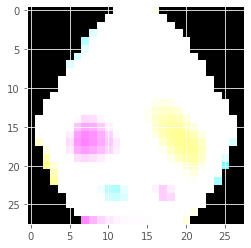

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


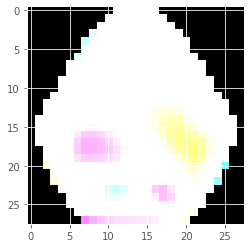

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


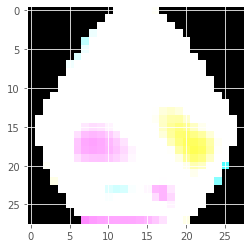

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


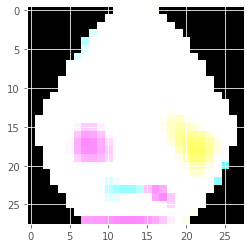

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


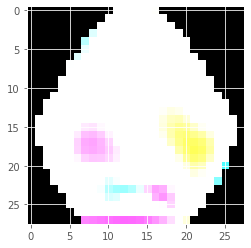

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


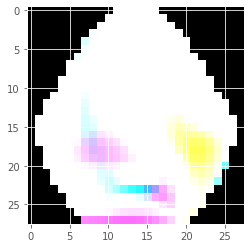

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


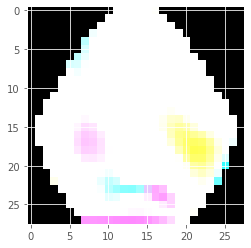

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


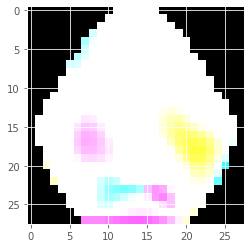

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


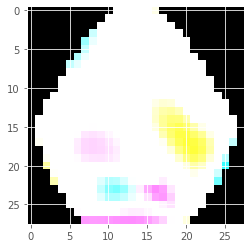

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


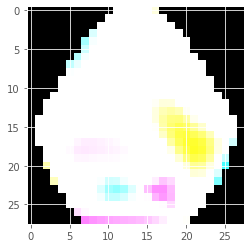

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


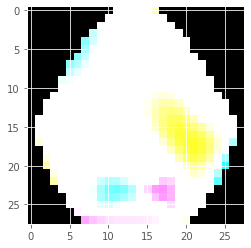

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


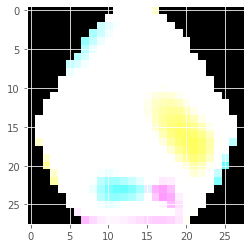

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


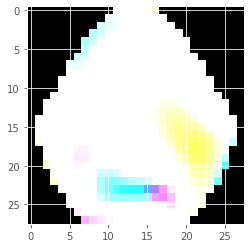

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


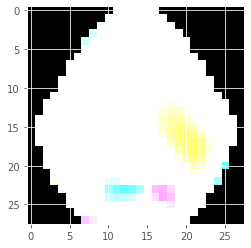

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


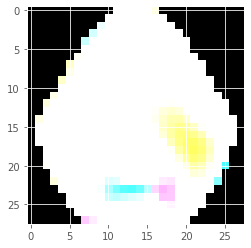

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


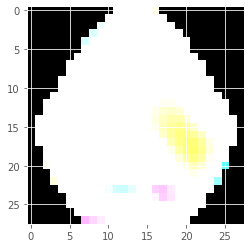

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


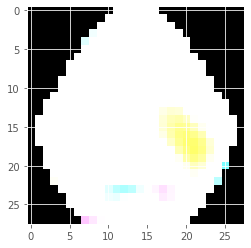

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


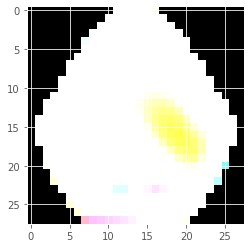

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


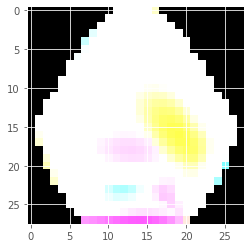

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.0


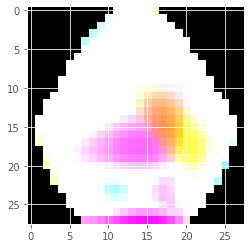

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(1990,2010):
    plt.imshow(X[i])
    print(y[i])
    plt.show()

In [76]:
from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05,shuffle=True)
#x_train = X
x_train = X_after
y_train = y

In [77]:
# input image dimensions
#img_rows, img_cols = 42, 128
#img_rows, img_cols = 128, 128
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
#X_test = x_test.astype('float32')
X_test = x_after_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (17654, 28, 28, 3)
17654 train samples
2522 test samples


In [78]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 32
num_classes = 3
#epochs = 350
#epochs = 100
epochs = 200

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
#model.add(Activation('sigmoid'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
X_test = X_test.astype('float32')
#x_train /= 255
#x_test /= 255


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True)

Train on 17654 samples, validate on 2522 samples
Epoch 1/200
17654/17654 [==============================] - 8s 435us/step - loss: 1.0938 - accuracy: 0.3586 - val_loss: 1.0869 - val_accuracy: 0.3362
Epoch 2/200
17654/17654 [==============================] - 7s 419us/step - loss: 1.0716 - accuracy: 0.4162 - val_loss: 1.0874 - val_accuracy: 0.3275
Epoch 3/200
17654/17654 [==============================] - 7s 416us/step - loss: 1.0495 - accuracy: 0.4593 - val_loss: 1.0606 - val_accuracy: 0.3929
Epoch 4/200
17654/17654 [==============================] - 7s 417us/step - loss: 1.0303 - accuracy: 0.4765 - val_loss: 1.0520 - val_accuracy: 0.4290
Epoch 5/200
17654/17654 [==============================] - 7s 416us/step - loss: 1.0081 - accuracy: 0.5031 - val_loss: 1.0720 - val_accuracy: 0.4064
Epoch 6/200
17654/17654 [==============================] - 7s 418us/step - loss: 0.9861 - accuracy: 0.5279 - val_loss: 1.0954 - val_accuracy: 0.3775
Epoch 7/200
17654/17654 [==============================] 

17654/17654 [==============================] - 9s 486us/step - loss: 0.6333 - accuracy: 0.7281 - val_loss: 1.4540 - val_accuracy: 0.4556
Epoch 56/200
17654/17654 [==============================] - 8s 472us/step - loss: 0.6297 - accuracy: 0.7299 - val_loss: 1.3949 - val_accuracy: 0.4778
Epoch 57/200
17654/17654 [==============================] - 7s 419us/step - loss: 0.6290 - accuracy: 0.7307 - val_loss: 1.3150 - val_accuracy: 0.4944
Epoch 58/200
17654/17654 [==============================] - 8s 472us/step - loss: 0.6268 - accuracy: 0.7284 - val_loss: 1.5850 - val_accuracy: 0.4572
Epoch 59/200
17654/17654 [==============================] - 8s 470us/step - loss: 0.6249 - accuracy: 0.7313 - val_loss: 1.4117 - val_accuracy: 0.4481
Epoch 60/200
17654/17654 [==============================] - 8s 473us/step - loss: 0.6204 - accuracy: 0.7346 - val_loss: 1.5280 - val_accuracy: 0.4473
Epoch 61/200
17654/17654 [==============================] - 8s 470us/step - loss: 0.6200 - accuracy: 0.7345 - val

17654/17654 [==============================] - 7s 415us/step - loss: 0.5419 - accuracy: 0.7716 - val_loss: 1.5138 - val_accuracy: 0.5309
Epoch 110/200
17654/17654 [==============================] - 7s 416us/step - loss: 0.5422 - accuracy: 0.7697 - val_loss: 1.9124 - val_accuracy: 0.4635
Epoch 111/200
17654/17654 [==============================] - 7s 419us/step - loss: 0.5415 - accuracy: 0.7727 - val_loss: 1.6333 - val_accuracy: 0.5194
Epoch 112/200
17654/17654 [==============================] - 7s 417us/step - loss: 0.5405 - accuracy: 0.7688 - val_loss: 1.7806 - val_accuracy: 0.4849
Epoch 113/200
17654/17654 [==============================] - 7s 417us/step - loss: 0.5373 - accuracy: 0.7739 - val_loss: 1.4602 - val_accuracy: 0.5551
Epoch 114/200
17654/17654 [==============================] - 7s 416us/step - loss: 0.5393 - accuracy: 0.7704 - val_loss: 1.4642 - val_accuracy: 0.5194
Epoch 115/200
17654/17654 [==============================] - 7s 417us/step - loss: 0.5346 - accuracy: 0.7756

17654/17654 [==============================] - 7s 418us/step - loss: 0.4903 - accuracy: 0.7949 - val_loss: 1.8219 - val_accuracy: 0.5063
Epoch 164/200
17654/17654 [==============================] - 7s 416us/step - loss: 0.4895 - accuracy: 0.7943 - val_loss: 2.0855 - val_accuracy: 0.4837
Epoch 165/200
17654/17654 [==============================] - 7s 417us/step - loss: 0.4888 - accuracy: 0.7953 - val_loss: 2.1167 - val_accuracy: 0.4984
Epoch 166/200
17654/17654 [==============================] - 7s 418us/step - loss: 0.4863 - accuracy: 0.7956 - val_loss: 2.1291 - val_accuracy: 0.5119
Epoch 167/200
17654/17654 [==============================] - 7s 418us/step - loss: 0.4870 - accuracy: 0.7944 - val_loss: 2.2201 - val_accuracy: 0.5079
Epoch 168/200
17654/17654 [==============================] - 7s 417us/step - loss: 0.4868 - accuracy: 0.7957 - val_loss: 2.1459 - val_accuracy: 0.4865
Epoch 169/200
17654/17654 [==============================] - 7s 419us/step - loss: 0.4877 - accuracy: 0.7957

In [58]:
model.evaluate(X_test, y_test)

2522/2522 [==============================] - 0s 190us/step


[2.0654810721100465, 0.5079302191734314]

In [59]:
model.evaluate(x_test_1, keras.utils.to_categorical(y_test_1, num_classes))

840/840 [==============================] - 0s 204us/step


[4.643183163234165, 0.014285714365541935]

In [60]:
model.evaluate(x_test_0, keras.utils.to_categorical(y_test_0, num_classes))

836/836 [==============================] - 0s 207us/step


[1.526959521918776, 0.5131579041481018]

In [61]:
model.evaluate(x_test_2, keras.utils.to_categorical(y_test_2, num_classes))

846/846 [==============================] - 0s 314us/step


[0.03821655947618169, 0.9929078221321106]

In [22]:
1.42
51.31
99.29

In [61]:
model.evaluate(X_test, keras.utils.to_categorical(y_test, num_classes))

796/796 [==============================] - 2s 2ms/step


[0.637220244611328, 0.6457286477088928]

In [62]:
model.evaluate(X_test_1, keras.utils.to_categorical(y_test_1, num_classes))

398/398 [==============================] - 1s 2ms/step


[0.6389172658249361, 0.8190954923629761]

In [63]:
model.evaluate(X_test_0, keras.utils.to_categorical(y_test_0, num_classes))

398/398 [==============================] - 1s 2ms/step


[0.7973151060205009, 0.18090452253818512]

In [19]:
model.save('model_g.h5')

# Res NET 50

In [239]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [240]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [241]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block = 'a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'b')
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'c')
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'd')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'b')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'c')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'd')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'e')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block = 'a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block = 'b')
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block = 'c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    #AveragePooling2D(pool_size = (1, 1), name = 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [242]:
model = ResNet50(input_shape = (64, 64, 3), classes = 2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [244]:
model.fit(x_train, to_categorical(y_train), epochs = 20, batch_size = 32, validation_split = 0.05)

Train on 3415 samples, validate on 180 samples
Epoch 1/20
3415/3415 [==============================] - 833s 244ms/step - loss: 0.8448 - accuracy: 0.5151 - val_loss: 0.9204 - val_accuracy: 0.4722
Epoch 2/20
3415/3415 [==============================] - 908s 266ms/step - loss: 0.8377 - accuracy: 0.5142 - val_loss: 0.8577 - val_accuracy: 0.5056
Epoch 3/20
3415/3415 [==============================] - 863s 253ms/step - loss: 0.9263 - accuracy: 0.5157 - val_loss: 0.7032 - val_accuracy: 0.5611
Epoch 4/20
3415/3415 [==============================] - 735s 215ms/step - loss: 0.8456 - accuracy: 0.5209 - val_loss: 1.0259 - val_accuracy: 0.5389
Epoch 5/20
3415/3415 [==============================] - 770s 226ms/step - loss: 0.8968 - accuracy: 0.5300 - val_loss: 0.8275 - val_accuracy: 0.5056
Epoch 6/20
3415/3415 [==============================] - 757s 222ms/step - loss: 0.7527 - accuracy: 0.5286 - val_loss: 0.7174 - val_accuracy: 0.5222
Epoch 7/20
3415/3415 [==============================] - 786s 230m

In [ ]:
model.evaluate(x_test, to_categorical(y_test))

352/400 [=========================>....] - ETA: 1s

# Other

In [312]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model = DeepConvNet(2, picsize= 64, dropoutRate = 0.5)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

AttributeError: 'Node' object has no attribute 'output_masks'

# Prepare data for old models

In [8]:
check = pd.read_csv('New_data_29_04\\data_train_new_appr_1_label1.csv')
check.shape

(20000, 14)

In [22]:
def prepare_data_to_old(df, label, sample_start):
    l = []
    for i in range(sample_start, sample_start+200):
        l = l + [i]*100
    print(len(l))
    df['sample_num'] = l
    df['label'] = label
    return df

In [23]:
labels = [1,0,1,0,0,1,0,1,0,1,0,1,0,1]
df_1 = pd.read_csv('New_data_29_04\\data_train_new_appr_1_label1.csv')
df_2 = pd.read_csv('New_data_29_04\\data_train_new_appr_2_label0.csv')
df_3 = pd.read_csv('New_data_29_04\\data_train_new_appr_3_label1.csv')
df_4 = pd.read_csv('New_data_29_04\\data_train_new_appr_4_label0.csv')
df_5 = pd.read_csv('New_data_29_04\\data_train_new_appr_5_label0.csv')
df_6 = pd.read_csv('New_data_29_04\\data_train_new_appr_6_label1.csv')
df_7 = pd.read_csv('New_data_29_04\\data_train_new_appr_7_label0.csv')
df_8 = pd.read_csv('New_data_29_04\\data_train_new_appr_8_label1.csv')
df_9 = pd.read_csv('New_data_29_04\\data_train_new_appr_9_label0.csv')
df_10 = pd.read_csv('New_data_29_04\\data_train_new_appr_10_label1.csv')
df_11 = pd.read_csv('New_data_29_04\\data_train_new_appr_11_label0.csv')
df_12 = pd.read_csv('New_data_29_04\\data_train_new_appr_12_label1.csv')
df_13 = pd.read_csv('New_data_29_04\\data_train_new_appr_13_label0.csv')
df_14 = pd.read_csv('New_data_29_04\\data_train_new_appr_14_label1.csv')
l = [df_1, df_2, df_3, df_4, df_5, df_6, df_7,
       df_8, df_9, df_10, df_11, df_12, df_13, df_14]
sample_start = 0
k = 0
df_all = pd.DataFrame()
for i, j in zip(l, labels):
    if k == 0:
        df_all = prepare_data_to_old(i, j, sample_start)
        sample_start = sample_start + 200
    else:
        df_all = pd.concat([df_all, prepare_data_to_old(i, j, sample_start)])
        sample_start = sample_start + 200
    k = k+1

20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000


In [28]:
df_all['sample_num']

0           0
1           0
2           0
3           0
4           0
         ... 
19995    2799
19996    2799
19997    2799
19998    2799
19999    2799
Name: sample_num, Length: 280000, dtype: int64

In [29]:
df_all.to_csv('df_all.csv')